# Notebook Overview

## TL;DR

* 

Still to do
* Decide on order of data exploration.  
    * Need to sort out discounts, so start with StockCode & Description
    * CustomerID, Country
    * InvoiceNo, Invoice Date, 
    * Finish with Q & P & make Total Cost column
    
* Finish going through each column
* Copy code from datA_exploration notebook
* delete data_exploration notebook
* update the numbering on the notebooks
* carry on with next notebook

useful link (medium article)[https://towardsdatascience.com/an-extensive-guide-to-exploratory-data-analysis-ddd99a03199e]
useful kaggle [https://www.kaggle.com/hellbuoy/online-retail-k-means-hierarchical-clustering]

# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Set Seaborn Parameters

In [2]:
plt.rcParams["figure.figsize"] = (10, 5)

sns.set_style = "seaborn-whitegrid"

sns.set(
    rc={
        "font.style": "normal",
        "axes.facecolor": "white",
        "grid.color": ".8",
        "grid.linestyle": "-",
        "figure.facecolor": "white",
        "figure.titlesize": 20,
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "axes.grid": True,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "font.size": 10,
        "ytick.labelsize": 10,
    }
)

# Import Data

In [3]:
df = pd.read_excel("../data/Online Retail.xlsx",
                   engine='openpyxl')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Data Overview

In [4]:
# Display the number of rows and columns for the dataset
df.shape

(541909, 8)

In [5]:
# Print a concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
# Show the number of unique values in each column
df.nunique(axis=0)

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [7]:
# Summary of numeric variables
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


* Negative values in "Quantity" seems odd, and will require further exploration
* The max values in "Quantity" and "UnitPrice" also seem odd when compared to the mean and standard deviation

## Remove rows

### Null Values

In [46]:
# Show the percentage of missing values for each column
print('Percentage of each column that is a null value')
print('---'*15)
print(round(df.isnull().mean() * 100, 2))

Percentage of each column that is a null value
---------------------------------------------
InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64


* Only "Description" and "CustomerID" have missing values.
* In rows with no "Description", we still have other useful information, such as "StockCode" and "UnitPrice".  We should **keep the rows which are only missing "Description"**.
* Our aim is to segment Customers.  If we don't know which customer made a particular purchase we no longer require the rest of the row's data.  We can therefore **drop the rows without a "CustomerID"**.

#### Drop CustomerID Null Values

* Our objective requires identifying which customer made a particular purchase, with no data, the row/transaction is of no use to us. 

In [51]:
## Drop rows with no "CustomerID"
rows_before = df.shape[0]
df.dropna(subset=['CustomerID'], inplace=True)
rows_after = df.shape[0]

# Display how many rows were dropped
print('Dropped {} rows with no value in "CustomerID"'.format(rows_before-rows_after))

# Shown as a percentage
drop_pct = round((100 * (rows_before-rows_after)/rows_before), 2)
print('This represents {}% of the data'.format(drop_pct))

Dropped 0 rows with no value in "CustomerID"
This represents 0.0% of the data


### Drop Duplicate Rows

In [101]:
print('There are {} potentially duplicated rows'.format(df.duplicated().sum()))
print('Below are the first 3 duplicated rows')

# First 5 duplicated entries
df[df.duplicated()].head(3)

There are 5192 potentially duplicated rows
Below are the first 3 duplicated rows


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom


* Let's take a closer look at the first duplicated row

In [102]:
# Invoiceno of 1st duplicated row
example_invoiceno = df[df.duplicated()].iloc[0,:]['InvoiceNo']

# Description of 1st duplicated row
example_description = df[df.duplicated()].iloc[0,:]['Description']

# Show the duplicates in this invoice
df[(df['InvoiceNo']==example_invoiceno) & (df['Description']==example_description)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom


* For the purpose of this exercise we will assume that this is an error and **remove the duplicate rows**.  If the duplicates are not wrong, then the approach should be to adjust the quantity appropriately.

In [106]:
print('We decide to drop {} duplicated rows'.format(df.duplicated().sum()))
df.drop_duplicates(inplace = True)

We decide to drop 5192 duplicated rows


## Change Data Types

* The values in some columns merely represent unique values, and do not indicate a relationship to other values.  e.g. a CustomerID of 1000 is not twice the value of a CustomerID of 500.  The opposite would be something like UnitPrice, where 1000 is indeed twice the value of 500.  
* These columns will not be used by our algorithms, however to avoid confusion, these unique ID columns ('InvoiceNo', 'StockCode', 'CustomerID') should contain data as a string type.

In [11]:
# "InvoiceNo"
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

# "StockCode"
df['StockCode'] = df['StockCode'].astype(str)

# "CustomerID"
df['CustomerID'] = df['CustomerID'].astype(str)

# Exploration of columns

* We begin by taking a high level view of the quantity of unique Products (`StockCode`), Customers (`CustomerID`) and Transactions (`StockCode`)

In [114]:
# Gather the total unique values in the 3 columns
count_customerid = df['CustomerID'].nunique()
count_stockcode = df['StockCode'].nunique()
count_invoiceno = df['InvoiceNo'].nunique()

pd.DataFrame([{'Customers': count_invoiceno, 
               'Products': count_stockcode, 
               'Transactions': count_stockcode}], 
             index = ['Quantity'])
                    

,Customers,Products,Transactions
Quantity,18536,3665,3665


## ID Columns

### InvoiceNo

SORT OUT WHAT IM DOING FOR THE REFUNDS/DISCOUNTS

* If an invoice is a refund, the InvoiceNo will begin with C

In [12]:
df[df['InvoiceNo'].str.match('C')].head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom


* We are not concerned with refunds or discounts so should drop these rows

In [13]:
# Drop rows with InvoiceNo beggining with "C"
df = df[~df['InvoiceNo'].str.match('C')]

### StockCode

* StockCode with value of M = Manual, which still leaves valuable information, so no rows will be dropped.

In [14]:
df[df['StockCode'].str.len() < 2].head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274.0,United Kingdom
2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274.0,United Kingdom
6798,536981,M,Manual,2,2010-12-03 14:26:00,0.85,14723.0,United Kingdom


## Description

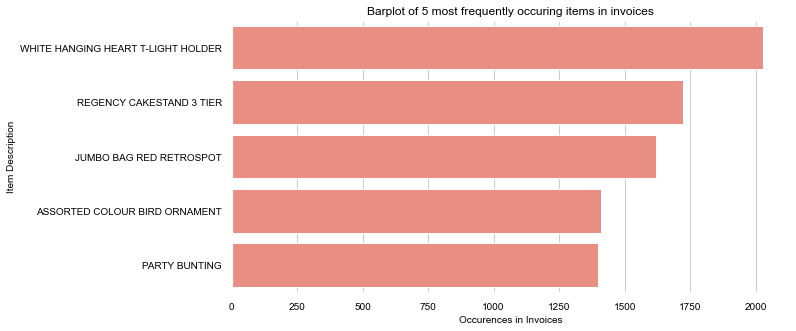

In [15]:
# Plot of most popular items
n = 5
most_frequent_items = df['Description'].value_counts()[:n]

# Plot
ax = sns.barplot(x = most_frequent_items, 
                 y = most_frequent_items.index, color='salmon')

# Set titles
ax.set(title = 'Barplot of {} most frequently occuring items in invoices'.format(n), 
       xlabel= 'Occurences in Invoices', 
       ylabel= 'Item Description');

## Quantity

* NB We have removed negative Quantity values (refunds, discounts)
* Some Quantities seemed oddly large at first inspection of the dataframe

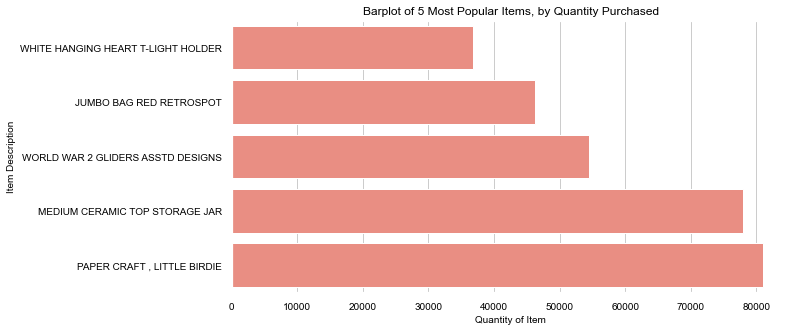

In [16]:
# Most Popular Products by Quantity
n = 5
highest_quantity_items = df[['Description', 'Quantity']].groupby('Description').sum().sort_values(by=['Quantity'])[-n:]

# Plot
ax = sns.barplot(x = highest_quantity_items['Quantity'], 
            y = highest_quantity_items.index, 
            color='salmon')

# Set titles
ax.set(title ='Barplot of {} Most Popular Items, by Quantity Purchased'.format(n), 
       xlabel='Quantity of Item', 
       ylabel='Item Description');

* Look at how many invoices made up these top items shown above

In [17]:
print('Invoices\t Item Description')
print('---'*15)

for item in list(highest_quantity_items.index):
    num_of_invoices_for_item = len(df[df['Description']==item])    
    print(num_of_invoices_for_item, '\t'*2, item)

Invoices	 Item Description
---------------------------------------------
2028 		 WHITE HANGING HEART T-LIGHT HOLDER
1618 		 JUMBO BAG RED RETROSPOT
473 		 WORLD WAR 2 GLIDERS ASSTD DESIGNS
198 		 MEDIUM CERAMIC TOP STORAGE JAR
1 		 PAPER CRAFT , LITTLE BIRDIE


* There was only 1 invoice which purchased the full 'PAPER CRAFT , LITTLE BIRDIE' of 80995

In [19]:
df[df['Description']=='PAPER CRAFT , LITTLE BIRDIE']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom


* The vast majority of MEDIUM CERAMIC TOP STORAGE JARs was in 1 invoice

In [20]:
# Largest purchases of 'MEDIUM CERAMIC TOP STORAGE JAR'
n = 5
df_jar = df[df['Description']=='MEDIUM CERAMIC TOP STORAGE JAR']
df_jar.sort_values(by = 'Quantity', ascending=False).head(n)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
285367,561901,23166,MEDIUM CERAMIC TOP STORAGE JAR,288,2011-07-31 15:42:00,1.25,14156.0,EIRE
194462,553607,23166,MEDIUM CERAMIC TOP STORAGE JAR,240,2011-05-18 10:47:00,1.04,16684.0,United Kingdom
276513,561051,23166,MEDIUM CERAMIC TOP STORAGE JAR,144,2011-07-24 13:11:00,1.04,16684.0,United Kingdom
526381,580665,23166,MEDIUM CERAMIC TOP STORAGE JAR,96,2011-12-05 14:06:00,1.04,16684.0,United Kingdom


In [21]:
print('Median Quantity:\t\t',df_jar['Quantity'].median())
proportion = round(df_jar['Quantity'].max()/df_jar['Quantity'].sum(), 2)
print('Proportion in largest invoice:\t', proportion)

Median Quantity:		 12.0
Proportion in largest invoice:	 0.95


## InvoiceDate

Key Metrics 
 ------------
Min:	1
Max:	542
Median:	16.0


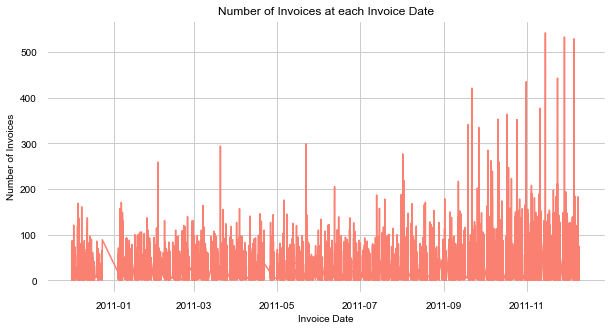

In [22]:
# Group by how many invoices at each InvoiceDate
df_date = df.groupby('InvoiceDate').count()['Quantity']

# Print key metrics
print('Key Metrics','\n','----'*3)
print('Min:\t{}'.format(df_date.min()))
print('Max:\t{}'.format(df_date.max()))
print('Median:\t{}'.format(df_date.median()))

# Plot
ax = sns.lineplot(x = df_date.index, y = df_date, color='salmon') 

# Set titles
ax.set(title ='Number of Invoices at each Invoice Date', 
       xlabel='Invoice Date', 
       ylabel='Number of Invoices');

## UnitPrice

In [23]:
df['UnitPrice'].describe()

count    397924.000000
mean          3.116174
std          22.096788
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64

In [24]:
n = 0
n_price = len(df[df['UnitPrice']==n])
print('There are {} Items Where Price is {}'.format(n_price, n))

There are 40 Items Where Price is 0


* These are presumably discounted.  Doesn't seem useful for segmenting

In [25]:
unique_prices = sorted(df['UnitPrice'].unique())

n = 5
# Lowest Prices
print('Lowest {} Prices:\t'.format(n), unique_prices[:5])

# Highest Prices
print('Highest {} Prices:\t'.format(n), unique_prices[-5:])

Lowest 5 Prices:	 [0.0, 0.001, 0.04, 0.06, 0.07]
Highest 5 Prices:	 [2500.0, 3155.95, 3949.32, 4161.06, 8142.75]


* See which other numbers are posisbly incorreclty inputted with too many decimal places (like 0.001)

In [26]:
unique_prices = df['UnitPrice'].unique()
unique_prices[:5]

array([2.55, 3.39, 2.75, 7.65, 4.25])

In [27]:
# Multiply each price by 100
unique_prices_100 = [price * 100 for price in unique_prices]

# Remove integer, leaving only numbers with 3 decimal places or more in original price
unique_prices_3dp = [(unique_price_100 - int(unique_price_100))/100 for unique_price_100 in unique_prices_100]

print('There are {} Unit Prices that have 3 decimal places or more'.format(len(unique_prices_3dp)))

There are 441 Unit Prices that have 3 decimal places or more


* This could be accredited to the different currencies involved, and the exchange rate used.

## CustomerID

In [28]:
df['CustomerID'].unique()

array(['17850.0', '13047.0', '12583.0', ..., '13298.0', '14569.0',
       '12713.0'], dtype=object)

In [29]:
# Validation check to see if CustomerIDs are of the same length

# Create list of the length of each CustomerID
custid_len = [len(x) for x in df['CustomerID']]

# See the unique values in the list
set(custid_len)

{7}

* All CustomerIDs are therefore 7 digits long. 

## Country

* Look at the most common countries.

In [41]:
print('There are {} unique countries in the data'.format(df['Country'].nunique()))

There are 37 unique countries in the data


In [30]:
# Take only the top 5 most common countries by transaction number
df_country_top5 = df['Country'].value_counts()[:5]
# Add 'Other' row, for sum of countries not in the top 5
df_country_top5_other = pd.Series([df['Country'].value_counts()[5:].sum()], index=['Other'])
# Add to 'Country' Series
df_country_top5 = df_country_top5.append(df_country_top5_other)
df_country_top5

United Kingdom    354345
Germany             9042
France              8342
EIRE                7238
Spain               2485
Other              16472
dtype: int64

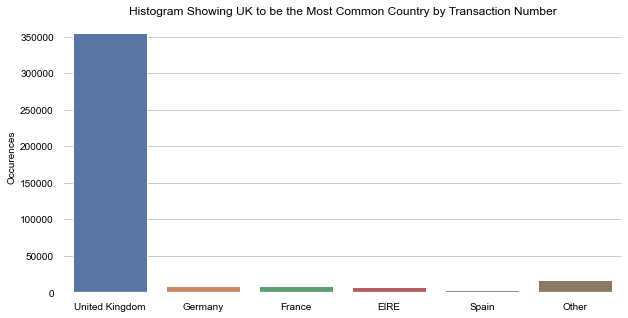

In [42]:
ax = sns.barplot(x=df_country_top5.index, y=df_country_top5)

ax.set(title='Histogram Showing UK to be the Most Common Country by Transaction Number', ylabel = 'Occurences');

* Clearly the UK is the most common, when we look at countries for each line in the invoices
* Might be interesting to look at where the customers mostly come from

In [32]:
# Group the dataframe by CustomerID, whilst also displaying the country the CustomerID is from
df_customer_countries = df.groupby(['CustomerID', 'Country']).count()
df_customer_countries.head(2)

,,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice
CustomerID,Country,,,,,,
12346.0,United Kingdom,1,1,1,1,1,1
12347.0,Iceland,182,182,182,182,182,182


In [33]:
# Move 'CustomerID' and 'Country' from index, and only keep those 2 columns
df_customer_countries = df_customer_countries.reset_index()[['CustomerID', 'Country']]
df_customer_countries.head(2)

,CustomerID,Country
0,12346.0,United Kingdom
1,12347.0,Iceland


In [34]:
# Number of customers from each country
customer_per_country = df_customer_countries.groupby(by='Country').count().sort_values(by='CustomerID', ascending=False)
# Take the top 5 countries
df_customer_countries = customer_per_country[:5]
# Group the other countries into an Other row
df_customer_countries_other = pd.Series(data=customer_per_country[5:].sum(), index=['CustomerID'], name='Other')
# # Add to 'Country' Series
df_customer_countries = df_customer_countries.append(df_customer_countries_other)
df_customer_countries

,CustomerID
Country,
United Kingdom,3921
Germany,94
France,87
Spain,30
Belgium,25
Other,190


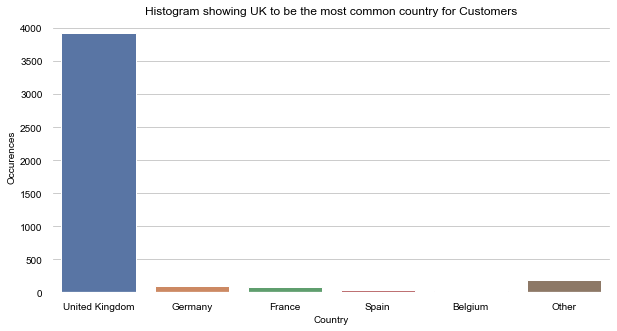

In [35]:
ax = sns.barplot(x=df_customer_countries.index, y=df_customer_countries['CustomerID'])

ax.set(title='Histogram showing UK to be the most common country for Customers', ylabel = 'Occurences');

* The chart clearly shows the UK as the most popular Country for Customers

In [36]:
# Add Useful Columns

In [37]:
# Add a TotalPrice column based on Quantity multiplied by UnitPrice
# df['TotalPrice'] = df.loc[:,'Quantity'] * df.loc[:,'UnitPrice']

# Save Processed DataFrame as a CSV

In [38]:
# Save as csv file, which is more compatible with pandas
df.to_csv('../data/online_retail_processed')